# Data-Driven Monge's Partition 

There are many service centers in our city, such as MTA subway station, Vaccination sites, Wifi hot-spots, Blue Bicycles, hospitals, parking lots etc.. Meanwhile, there are so many people in need of these services who are distributed maybe according to some point processes. The question of how to efficiently make assignments between the demands and the service centers gives rise to a special type of problems called semi-discrete optimal transport. 

In this notebook I am going to explore how this semi-discrete optimal transport is solved through Monge's partition and how this partition can be achieved using some geospatial data. 


## Preliminary Setting 
Let us denote the entire space as $\mathcal{X}$, (in a lot of cases this $\mathcal{X}$ is just some hull in a 2D plane.) 
The dirac-delta measure of service centers is $\nu = \sum_{i=1}^S \nu_s \delta_{x_s}$, where $x_s \in \mathcal{X} \ \ s = 1, \ldots, S$ are $S$ resource centers. 
The demand processes is a Poisson point process $\eta: \mathcal{X} \to \mathbf{N}$ ($\mathbf{N}$ is some $\sigma$-finite measure) with intensity measure $\lambda: \mathcal{X} \to \mathbb{R}_+$.

The public utility of assgining a demand point $x \in \mathcal{X}$ to service center $x_s$ is $u_s(\cdot): \mathcal{X} \to \mathbb{R}$. We assume this utility is $u_s(x) =  C - \|x - x_s\|^2$, where $C$ is some constant.


### The Matching Problem

First look at a natural possible solution where we partition the entire map so that each site is assigned some ''governed area'',
the allocation takes a form of an open subpartition of $\mathcal{X}$. 

***Definition***
The set of such allocation rule is:
\begin{equation*}
    \mathcal{A} = \left\{\mathbf{A} = (A_1, \ldots, A_S), A_s \text{ is an open subset of }\mathcal{X}, A_s \bigcap A_k = \emptyset \ \ \forall s \neq k\right\}|
\end{equation*}
and the unallocated set is $A_0 : = \mathcal{X} - \bigcup_{s=1}^S A_s$.

Now let the regional social welfare be $u(\mathbf{A})$, (i.e., the sum of utility,) by Campbell's formula
\begin{align*}
     u(\mathbf{A}) = & \sum_{s=1}^S \mathbb{E}\left[ \int_{A_s} u_s(x) \eta(dx) \right] \\
     = &\sum_{s=1}^S \int_{A_s} u_s(x)\lambda(dx)
\end{align*}

***The Problem*** 

The incentive of a public planner is to maximize the regional social welfare, under the constraint such that every service center is fully loaded, (under the assumption that total demand is saturated.)

\begin{align}
  \max_{\mathbf{A}\in \mathcal{A}}&\quad u(\mathbf{A})  \\
  \text{s.t. }&\quad \nu_s  \leq \lambda(A_s)  \ \ \ s = 1,\ldots, S .
\end{align}

#### Constructing Such a Problem

In the sequel I am going to construct the two densities needed for our problem.

I downloaded the data from [NYC Open Data](https://data.cityofnewyork.us/Health/New-York-City-Locations-Providing-Seasonal-Flu-Vac/w9ei-idxz/data), which provides the locations of seasonal flu vaccinatiion sites. Let's take a look at the locations by visualize it through $\texttt{seaborn}$.


In [38]:
import geopandas as gpd
import numpy as np
import pandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
#from sklearn.neighbors import KernelDensity

v_sites = pandas.read_csv(
    'data/New_York_City_Locations_Providing_Seasonal_Flu_Vaccinations.csv')
g_sites = gpd.GeoDataFrame(v_sites, geometry=gpd.points_from_xy(v_sites.Longitude, v_sites.Latitude))
g_sites.head()

,OBJECTID,A,Service Category,Service Type,Walk-in,Insurance,Children,Facility Name,Address,City,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,More Information,DOHMH Website,Location,geometry
0,646,748,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Newtown Pharmacy,28-04 31st Street,Astoria,...,NaN,NaN,NaN,NaN,NaN,NaN,Call location for hours,http://www1.nyc.gov/site/doh/health/health-top...,"28-04 31st Street\nAstoria\n(40.76832276, -73....",POINT (-73.92010 40.76832)
1,70,224,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Walgreens Drug Store,84-20 Broadway,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,Call location for hours,http://www1.nyc.gov/site/doh/health/health-top...,"84-20 Broadway\nQueens\n(40.73963768, -73.8781...",POINT (-73.87819 40.73964)
2,810,840,Vaccines,Flu Vaccine (Influenza),Yes,Yes,Yes,Homecrest Clinic,1601 AVENUE S,BROOKLYN,...,NaN,NaN,NaN,NaN,NaN,NaN,Call location for hours and information. Insur...,http://www1.nyc.gov/site/doh/health/health-top...,"1601 AVENUE S\nBROOKLYN\n(40.60359817, -73.956...",POINT (-73.95621 40.60360)
3,630,659,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Medcare Health Inc.,260 Kings Highway,Brooklyn,...,NaN,NaN,NaN,NaN,NaN,NaN,Call location for hours,http://www1.nyc.gov/site/doh/health/health-top...,"260 Kings Highway\nBrooklyn\n(40.60525733, -73...",POINT (-73.98105 40.60526)
4,366,182,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Duane Reade,949 3RD AVE,NEW YORK,...,NaN,NaN,NaN,NaN,NaN,NaN,Call location for hours,http://www1.nyc.gov/site/doh/health/health-top...,"949 3RD AVE\nNEW YORK\n(40.76012276, -73.96758...",POINT (-73.96758 40.76012)


<AxesSubplot:>

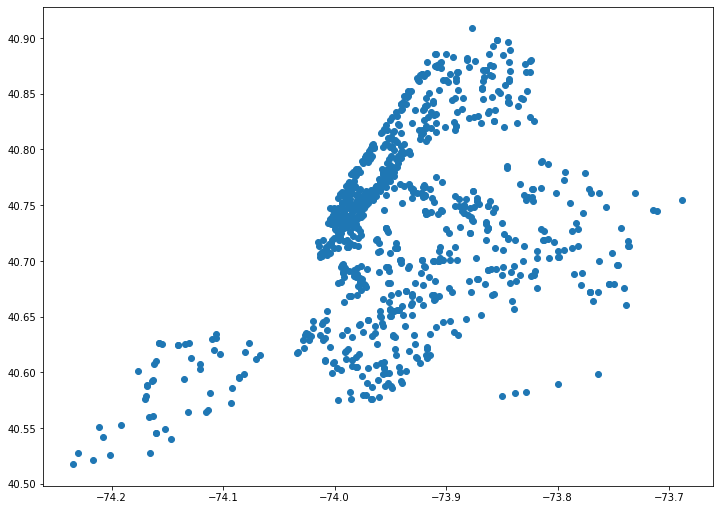

In [41]:
# The transformation into a geopandas dataframe
g_sites.plot(figsize = (12,12))

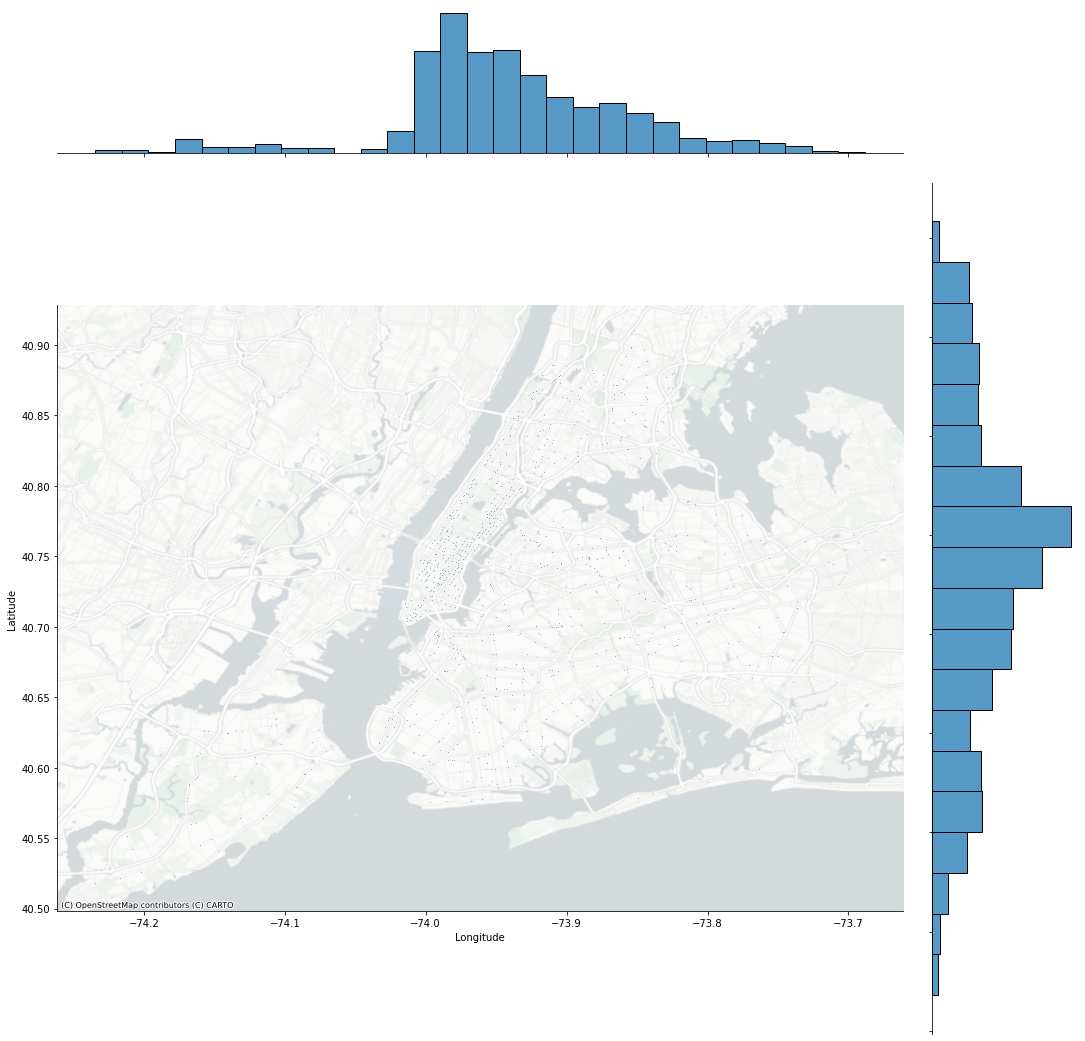

In [16]:
joint_axes = seaborn.jointplot(
    x='Longitude', y='Latitude', data=v_sites, s=0.8, height=15
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
)


In [17]:
# For simplicity we assume that the capacity is index-irrelevant, assgining uniform mass to every site. 
site_pos = np.vstack([v_sites.Longitude, v_sites.Latitude])
site_measure = {"pos": site_pos.T, "cap": (1/len(site_pos[0])) * np.ones(len(site_pos[0]))}



#### Kernel Density and Hexbin Plot as Two Types of Density Estimation

A hexbin plot is simply a hexagonal grid that counts how many points fall within each grid cell, so it is actually a *spatial* or *$2$-dimensional histogram*.

Kernel density estimator uses a non-parametric smooth kernel bump $\frac{1}{h}K(\frac{x - y}{h})$ such that $\int_{-\infty}^{\infty} \frac{1}{h}K(\frac{x - y}{h})dx = 1$ and $\int_{-\infty}^{\infty} \frac{x}{h}K(\frac{x - y}{h})dx = 0 $ to describe the grid bins. The approximated density in $2$-dimensional case is:
\begin{equation*}
  f(x, y) = \frac{1}{n} \sum_{i=1}^n \frac{1}{h_1 h_2} K(\frac{x - X_i}{h_1}) K(\frac{y - Y_i}{h_2})
\end{equation*}
Often times we simply choose $K(\frac{x - y}{h})$ to be Gaussian kernel:
$$
 K(x, y) \propto \exp(- \frac{\|x - y\|^2}{2h^2})
$$

Obviously for the discrete measure we do not need this type of modeling, so it is just for illustration purpose. Later when we deal with diffusing measure we might need these density estimators.

/Users/union/anaconda3/envs/eco/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


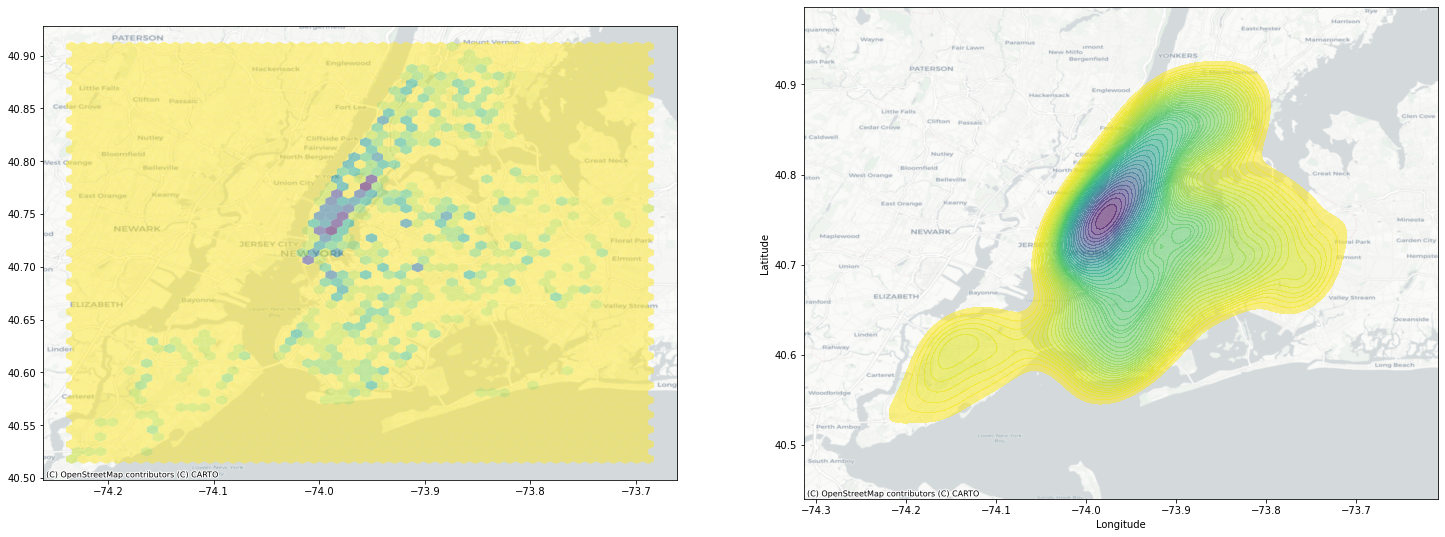

In [18]:

f, ax = plt.subplots(1, 2, figsize=(25, 18))

ax[0].hexbin(
    v_sites['Longitude'],
    v_sites['Latitude'],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap='viridis_r'
    
)


contextily.add_basemap(
    ax[0], crs="EPSG:4326",
    source=contextily.providers.CartoDB.Positron
)

ax[1] = seaborn.kdeplot(
    v_sites['Longitude'],
    v_sites['Latitude'],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap='viridis_r'
)

contextily.add_basemap(
    ax[1], crs="EPSG:4326",
    source=contextily.providers.CartoDB.Positron
)



#### What about the real density?
Now we have obtained the point locations, and we assigned uniform point masses to each of them representing the ''capacity'', so we are done constructing the first discrete measure. 

Now what we need is the populational density of demand. Unfortunately even the Poisson type of point data is unavailable, as it has to be the dataset of spatial-tagged disease cases. So,
to get the demand density distribution, we approximate it from a NYC census data, downloaded from [Kaggle Mapping New York City Census Data](https://www.kaggle.com/muonneutrino/mapping-new-york-city-census-data/data). There are two files we can consider. The first one being the census block, which contains the exact locations of the blocks being censored, the block codes, county and state names. The second one contains the census tracts, the county, borough names and exact populations calculated for each block.

Let's first merge the two pandas data frames to obtain the point data, each point contains all the information carried by the census tract statistics.

In [19]:
blocks = pandas.read_csv('data/census_block_loc.csv')
census = pandas.read_csv('data/nyc_census_tracts.csv', index_col=0)
blocks = blocks[blocks.County.isin(
    ['Bronx', 'Kings', 'New York', 'Queens', 'Richmond'])]
blocks['Tract'] = blocks.BlockCode // 10000
blocks = blocks.merge(census, how='left',
                      right_index=True, left_on='Tract')

blocks.head()


,Latitude,Longitude,BlockCode,County_x,State,Tract,County_y,Borough,TotalPop,Men,...,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
15,40.48,-74.232513,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,40.48,-74.229347,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,40.48,-74.226181,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,40.48,-74.223015,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,40.48,-74.219849,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Start From Populational Density
We choose the total population as a number that labels the specific points with their associated populational density, so still they form a discrete point measure. But it is at least helpful to visualize the populational density through some colormap.

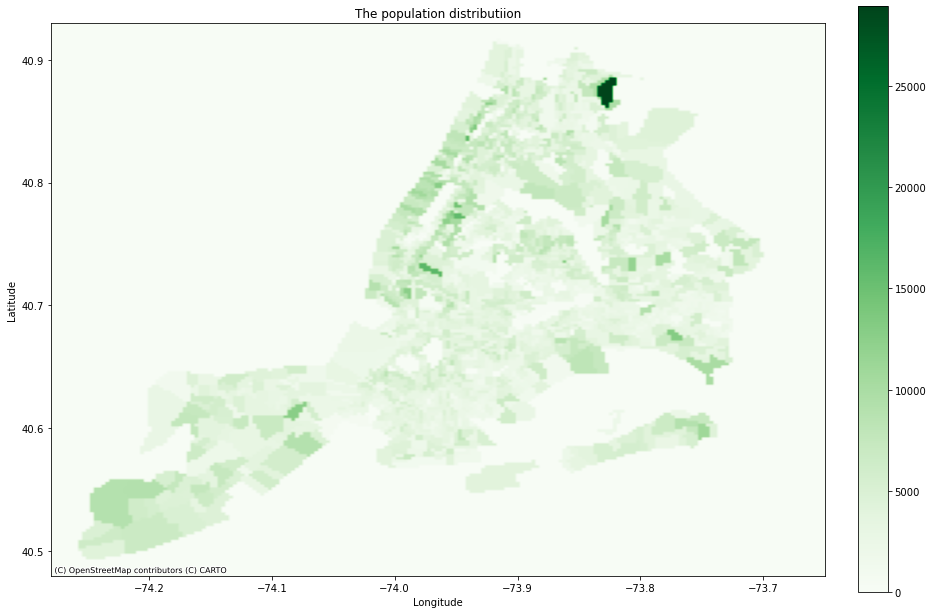

In [20]:
latmin = 40.48
lonmin = -74.28
latmax = 40.93
lonmax = -73.65

lat_vals = np.mgrid[latmin:latmax:200j]
lon_vals = np.mgrid[lonmin:lonmax:200j]

mp_vals = np.zeros([200, 200])

d_lat = lat_vals[1] - lat_vals[0]
d_lon = lon_vals[1] - lon_vals[0]

for lat, lon, val in zip(blocks.Latitude, blocks.Longitude, blocks.TotalPop):
    lat_idx = int(np.rint((lat - latmin) / d_lat))
    lon_idx = int(np.rint((lon - lonmin) / d_lon))
    if not np.isnan(val):
        mp_vals[lon_idx, lat_idx] = val

lon_mts = np.min(lon_vals), np.max(lon_vals)
lat_mts = np.min(lat_vals), np.max(lat_vals)

fig, ax = plt.subplots(figsize=(15,15)) 
ax.set(xlim=lon_mts, ylim=lat_mts)
contextily.add_basemap(ax, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron)

im = ax.imshow(mp_vals.T, origin='lower', cmap='Greens', extent=(np.min(lon_vals), np.max(lon_vals), np.min(lat_vals), np.max(lat_vals)))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('The population distributiion')
plt.colorbar(im, fraction=0.035, pad=0.04)

plt.show()



In [21]:
entire_pop = int(np.sum(blocks.TotalPop))
num_tracts = len(blocks.Longitude)
print("The entire population in NYC is {}, censored in {} tracts \n \
        The city area is in the bounded box of longitudes [{} {}] and latitudes [{} {}]".
        format(entire_pop, num_tracts, lon_mts[0], 
        lon_mts[1], lat_mts[0], lat_mts[1]))

The entire population in NYC is 52551009, censored in 18053 tracts 
         The city area is in the bounded box of longitudes [-74.28 -73.65] and latitudes [40.48 40.93]


Recall that the kernel density estimation is basically interpolating between the sampled points to predict the intensity of unsampled region, so the early view is that maybe we can also use the trick by fine-griding the entire 2D plane and apply the ''scaled'' version of density estimator, say
\begin{equation*}
   \hat{\lambda}(x, y) = \frac{1}{\sum_i pop_i h_x h_y} \sum_{i=1}^N pop_i K(\frac{x - x_i}{h_x}) K(\frac{y - y_i}{h_y}),
\end{equation*}
where $\hat{\lambda}(x, y)$ is the estimated density at longitude $y$ and latitude $x$, $pop_i$ is the censored total population at point $(x_i, y_i)$

To examine the correctness of this estimation, integrate the density over latitude and longitude
\begin{equation*}
    \int_{- \infty}^{\infty} \int_{-\infty}^{\infty} \frac{1}{\sum_i pop_i h_x h_y} \sum_{i=1}^N pop_i K(\frac{x - x_i}{h_x}) K(\frac{y - y_i}{h_y}) dx dy = \frac{1}{\sum_i pop_i} \sum_{i=1}^N pop_i \int_{- \infty}^{\infty} \frac{1}{h_x} K(\frac{x - x_i}{h_x}) dx \int_{-\infty}^{\infty} \frac{1}{h_y} K(\frac{y - y_i}{h_y})  dy  = \frac{1}{\sum_i pop_i} \sum_i pop_i = 1
\end{equation*}

Note that this demand estimation has some issues: first, it does not really make sense to integrate over an infinite 2-D plane, however for our application it's sufficient as the tail will ''fade'' near the boundary; second, we have to consider the plausibility to use census data as a source of demand sampling.  But since now I don't have many choices :(,  I will briefly use this for illustration purposes. If there are spatial-tagged discease data poping up, maybe then we can perform some more accurate geospatial analysis.

I am going to use the libary scipy Gaussian Kernel density estimation module to obtain the population density since it has the weighted implementation.

In [22]:
from scipy import stats

points = np.stack([np.array(blocks.Longitude), np.array(blocks.Latitude)])
pops = np.array(blocks.TotalPop)
pops[np.isnan(pops)] = 0

gkernel = stats.gaussian_kde(dataset=points, bw_method=None, weights=pops)

positions = np.stack([lat_vals.ravel(), lon_vals.ravel()])

Z = np.reshape(gkernel(positions).T, lon_vals.shape)

print('The kernel integration over the entire boundary is {}'.format(gkernel.integrate_box(low_bounds=[np.min(lon_vals), np.min(lat_vals)], high_bounds=[np.max(lon_vals), np.max(lat_vals)])))


The kernel integration over the entire boundary is 0.9917503652964066


Just to verify the estimated density is close to the data by plotting the heatmap of kernel integration. It turns out the 2-loop integration is quite slow, (about 20 mins). What we finally will get is a [200, 200] matrix representing the populational density on the map.

In [10]:
ker_vals = np.zeros((200, 200))
for lat_val in lat_vals:
    for lon_val in lon_vals:
        lat_idx = int(np.rint((lat_val - latmin) / d_lat))
        lon_idx = int(np.rint((lon_val - lonmin) / d_lon))
        #print("iter: lon {} lat {}".format(lat_idx, lon_idx))
        ker_vals[lon_idx, lat_idx] = gkernel.integrate_box(low_bounds=[lon_val, lat_val], high_bounds=[lon_val+d_lon, lat_val+d_lat])


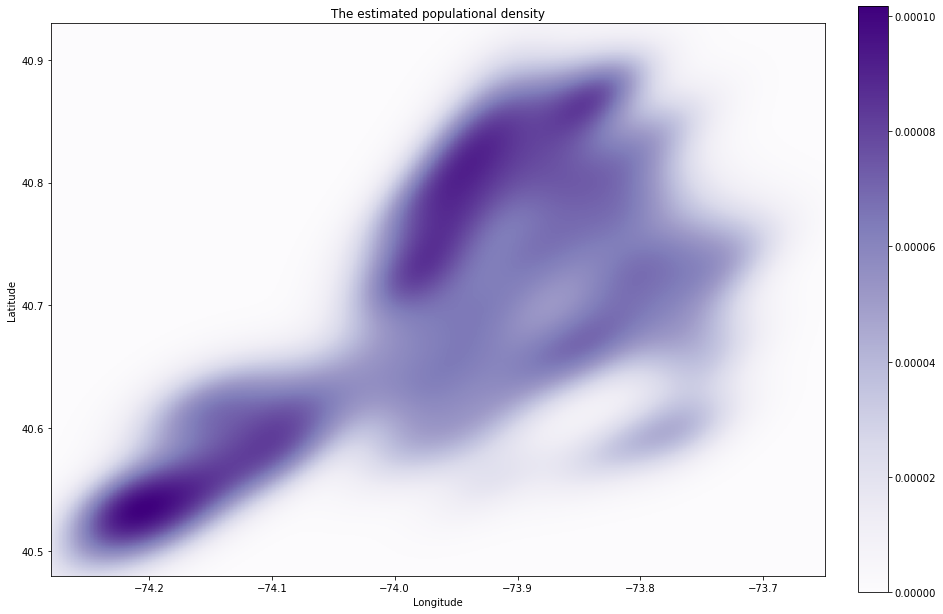

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set(xlim=lon_mts, ylim=lat_mts)
#contextily.add_basemap(ax, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron)
im = ax.imshow(ker_vals.T, origin='lower', cmap='Purples',
               extent=(np.min(lon_vals), np.max(lon_vals), np.min(lat_vals), np.max(lat_vals)))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('The estimated populational density')
plt.colorbar(im, fraction=0.035, pad=0.04)


plt.show()


## The Kantorovich Relaxation and Dual

It turns out the infinite dimensional problem can be solved by looking at its dual. 

Recall what we previously did is representing the transference plan $\operatorname{T}_{\#}$ as $\mathbf{A}$, where $\operatorname{T}_{\#}(x) = \sum_{x_s} x_s \mathbb{I}_{\{ x \in A_s\}}$.
What this transference plan means is that for every individual in location $x$, he or she is going to be sent site $x_s$ if $x$ is in the partition governed by $x_s$, i.e., $x \in A_s$.
However, we can define a more general transference plan that allows the splitting of population in the location $x$.

***Definition*** 
A weak relaxation is a set of non-negative measure over $\mathcal{X}$: 
\begin{equation*}
    \boldsymbol{\lambda} := (\lambda_1, \lambda_2, \ldots, \lambda_S) \quad  \sum_{i=1}^S \lambda_i \leq \lambda \quad \lambda_0 = \lambda - \sum_{i=1}^S \lambda_i
\end{equation*}


Consider a more general partition which assign each site a positive measure $\lambda_s$, such that $\int_{\mathcal{X}}\lambda_{s}=\nu_{s}$ and $\sum_{s \in \mathcal{S}} \lambda_{s} \leq \lambda $, in this form of assignment the demand of the entire area is divided by $\boldsymbol{\lambda}$ and assigned to corresponding sites. 

 The problem can be restated as finding a coupling $\pi \in \bar{\Pi}(\lambda, \nu)$ to maximize the total utility of assignment:

 \begin{align*}
     U &:= \max_{\pi \in \bar{\Pi}(\lambda, \nu)} \int_{\mathcal{X} \times \mathcal{X}} u(x, y)\pi(dx, dy) \\
      &= \max_{\pi \in \bar{\Pi}(\lambda, \nu)} \int_{\mathcal{X}}\sum_{s \in \mathcal{X}_{\mathcal{S}}} u(x, s) \pi(dx, s),
 \end{align*}

 where $\bar{\Pi}(\lambda, \nu)$ is defined as: 
 \begin{equation*}
    \bar{\Pi} (\lambda, \nu) = \left\{\sum_{s \in \mathcal{S}} \delta_{x_{s}}(d y) \otimes \lambda_{s}(dx), \text { where } \int_{\mathcal{X}} \lambda_{s}=\nu_{s} \text { and } \sum_{s \in \mathcal{S}} \lambda_{s} \leq \lambda .\right\}
 \end{equation*}

This set of coupling can be thought of as a sum of naive independent couplings between site measure $\nu$ and splitted population measures $\lambda_s$, the splitted population measure sum up to at most $\lambda$.



In analogue to the Monge-Kantorovich theory, define the set of dual profit-price pairs:
$$
\overline{\mathcal{J}}_{u}:=\{(\xi, p) \in C(\mathcal{X}) \times \mathbb{R}^{|S|} ; \quad \xi(x)+p_s \geq u(x, x_s) \ \ \forall(x, x_s) \in \mathcal{X} \times \mathcal{X}_{\mathcal{S}}\}.
$$    
This dual variable set has an interesting interpretation. Imagine you are a broker who helps the government to make vaccination recomendation for the customers by pricing the sites. For each customer at location $x$, you help the customer get $\xi(x)$ as a vaccination welfare, and if the customer goes to site $x_s$, and the government gets paid with price $p_s$. So the total utility made with your help is $ \xi(x) + p_s$ for customer $x$ going to site $x_s$, it has to satisfy that your interposition actually gives no shrinkage of the social welfare, i.e., $\xi(x)+p_s \geq u(x, x_s) $. 

The classical Kantorovich duality theorem says:

***Theorem***[Strong duality]
 If $\lambda(\mathcal{X}) = \nu(\mathcal{X})$, 
    $$
    U = \inf_{(\xi, p ) \in \overline{J}_u}\int_{\mathcal{X}}\xi d\lambda + \sum_{s \in \mathcal{S}} p_s \nu_s.
    $$
    
#### The Dual Program

Now we define a transformation that is related to the optimal pricing.

***Definition*** 
[$u$-transform]
For profit function $\xi \in \mathcal{C}(\mathcal{X})$, its $u$-transform is 
\begin{equation*}
    \xi^u_s = \sup_{x \in \mathcal{X}} u(x, x_s) - \xi(x)
\end{equation*}
for price vector $p \in \R^S$, its $u$-transform is 
\begin{equation*}
    p^u(x) = \sup_{s \in \mathcal{S}}u(x, x_s) - p_s
\end{equation*}

***Definition***
[$u$-convexity]
$\xi$ is $u$-convex if it satisfies that $\xi = p^u$ for some $p \in \mathbb{R}^S$, similarly, $p$ is $u$-convex if it satisfies that $p = \xi^u$ for some $\xi \in C(\mathcal{X})$. Denote the set of $u$-convex functions as $\mathcal{U}_{\xi}$ and $\mathcal{U}_p$. 

One important property is that $\xi$ is $u$-convex if.f $\xi^{uu} = \xi$, and the same holds for $p$. By this property it can be shown that $\R^S \subset \mathcal{U}_p  $ ($\forall p \in \R^S$, $p^{uu} = p$), thus $\mathcal{U}_p = \R^S$.
Without such simplification, the significance is that by \cite{villani2009optimal}, when the source and target measure is balanced one can narrow the searching scope in the set of $u$-convex functions $\mathcal{U}_{\xi}$ or $\mathcal{U}_{p}$.

#### Strong Duality Restate

***Theorem***[Strong duality (unbalanced)]
The primal problem can be reduced to its dual form: if $\lambda(\mathcal{X}) > \nu(\mathcal{X})$, then
     $$U = \inf_{p \in \mathcal{U}_p; p\geq 0} \int_{\mathcal{X}} [p^u]_+ d\lambda + \sum_{i=1}^Sp_i \nu_i,$$ where $[p^u]_+$ gives the optimal partition.


The advantage of such dual transform is that instead of directly looking for a infinite-dimensional partition, one optimize $p$ over finite dimensional space $\R^S_+$, computing $u$-transform of $p$ is equivalent to finding $p$-weighted partition, denoted as $\mathbf{A}^p = (A_1^p, \ldots, A^p_S)$, where
$$
A^p_s = \{x \in \mathcal{X} \ \ [u(x, x_s) - p_s]_+ \geq [u(x, x_j) - p_j]_+ \ \  \forall j \neq s\}
$$
Note that if $u(x,x_s)$ is the negative Euclidean distance plus a large constant, the partition coincides with $p$-weighted Voronoi diagram.

### Solution to the Dual

Let the dual objective function be $\Phi(\cdot): \R^S \to \R$, 
\begin{equation*}
    \Phi(p) = \int_{\mathcal{X}} \sup_{s\in \mathcal{S}}[u(x, x_s) - p_s]_+ d\lambda(x) + \sum_{s\in\mathcal{S}} p_s \nu_s
\end{equation*}

***Lemma***[Characterization of $\Phi$] $\Phi$ is convex and continuously differentiable with 
$$
         \frac{\partial \Phi (p)}{\partial p_s} = \nu_s - \lambda(A^p_s)  
$$
 
Thus we can leverage gradient descent $ p \leftarrow p  - \alpha_t \nabla_p \Phi$ to solve the problem. This gradient has a quite straightforward interpretation which is the demand-capacity differences. Intuitively if the demand is higher than the capacity then the price goes higher such that the assigned partition will be smaller, and vice versa.

Now we are at least ready to approach to the partition problem, with sites measure $\nu$, estimated density $\hat{\lambda}$, and shifted quadratic utility $u_s$. 
The first task is to calculate and plot $A_p$, it turns out that given a price $p$, the partition is just a set of adjacent polygons. 

We can plot that under no whatsoever assumptions about the demand density, i.e., population uniformly distributed, what the Voronoi-diagram looks like. But we have to develop some machinaries to calculate and display the polygons induced by the diagrams. The following code ([author: sunayana](https://gist.github.com/sunayana/a3a564058e97752f726ca65d56fab529)) provides an implementation to obtain the weighted voronoi cells. 

In [30]:
## from https://gist.github.com/sunayana/a3a564058e97752f726ca65d56fab529

import itertools
from scipy.spatial import ConvexHull
from matplotlib.collections import LineCollection

def disc_uniform_pick(N):
    angle = (2 * np.pi) * np.random.random(N)
    out = np.stack([np.cos(angle), np.sin(angle)], axis=1)
    out *= np.sqrt(np.random.random(N))[:,None]
    return out

def norm2(X):
    return np.sqrt(np.sum(X ** 2))

def normalized(X):
    return X / norm2(X)

## ------ Delaunay triangulation -----------------
def get_triangle_normal(A, B, C):
    return normalized(np.cross(A, B) + np.cross(B, C) + np.cross(C, A))

def get_power_circumcenter(A, B, C):
    N = get_triangle_normal(A, B, C)
    return (-.5 / N[2]) * N[:2] 

def is_ccw_triangle(A, B, C):
    M = np.concatenate([np.stack([A, B, C]), np.ones((3, 1))], axis=1)
    return np.linalg.det(M) > 0


def get_power_triangulation(S, R):
    # Compute the lifted weighted points
    S_norm = np.sum(S ** 2, axis=1) - R ** 2
    S_lifted = np.concatenate([S, S_norm[:, None]], axis=1)

    # Special case for 3 points
    if S.shape[0] == 3:
        if is_ccw_triangle(S[0], S[1], S[2]):
            return [[0, 1, 2]], np.array([get_power_circumcenter(*S_lifted)])
        else:
            return [[0, 2, 1]], np.array([get_power_circumcenter(*S_lifted)])

    # Compute the convex hull of the lifted weighted points
    hull = ConvexHull(S_lifted)

    # Extract the Delaunay triangulation from the lower hull
    tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [
                     a, c, b] for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)

    # Compute the Voronoi points
    V = np.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

    # Job done
    return tri_list, V


# --- Compute Voronoi cells ---------------------------------------------------

# Order the segments

def order_segment_list(segment_list):
    # Pick the first element
    first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

    # In-place ordering
    segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
    for i in range(len(segment_list) - 1):
        for j in range(i + 1, len(segment_list)):
            if segment_list[i][0][1] == segment_list[j][0][0]:
                segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                break

    # Job done
    return segment_list


'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''


def get_voronoi_cells(S, V, tri_list):
    # Keep track of which circles are included in the triangulation
    vertices_set = frozenset(itertools.chain(*tri_list))

    # Keep track of which edge separate which triangles
    edge_map = {}
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]

    # For each triangle
    voronoi_cell_map = {i: [] for i in vertices_set}

    for i, (a, b, c) in enumerate(tri_list):
        # For each edge of the triangle
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
            # Finite Voronoi edge
            edge = tuple(sorted((u, v)))
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j

                # Compute the segment parameters
                U = V[k] - V[j]
                U_norm = norm2(U)

                # Add the segment
                voronoi_cell_map[u].append(
                    ((j, k), (V[j], U / U_norm, 0, U_norm)))
            else:
                # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = S[u], S[v], S[w], V[i]
                U = normalized(B - A)
                I = A + np.dot(D - A, U) * U
                W = normalized(I - D)
                if np.dot(W, I - C) < 0:
                    W = -W

                # Add the segment
                voronoi_cell_map[u].append(
                    ((edge_map[edge][0], -1), (D,  W, 0, np.Inf)))
                voronoi_cell_map[v].append(
                    ((-1, edge_map[edge][0]), (D, -W, -np.Inf, 0)))

    # Job done
    return {i: order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items()}


# --- Plot all the things -----------------------------------------------------

def display(S, R, tri_list, voronoi_cell_map):
    # Setup
    fig, ax = plt.subplots(figsize = (18,12))
    plt.axis('equal')
    #plt.axis('off')

    # Set min/max display size, as Matplotlib does it wrong
    min_corner = np.amin(S, axis=0) - np.max(R)
    max_corner = np.amax(S, axis=0) + np.max(R)
    plt.xlim((min_corner[0], max_corner[0]))
    plt.ylim((min_corner[1], max_corner[1]))
    #print(min_corner[0], max_corner[0], min_corner[1], max_corner[1])
    # Plot the sites
    for Si, Ri in zip(S, R):
        ax.add_artist(plt.Circle(Si, 0.001, fill=True, alpha=.4,
                      lw=0., color='#8080f0', zorder=1))

    contextily.add_basemap(ax, crs="EPSG:4326",
                           source=contextily.providers.Stamen.TonerLabels)
    # Plot the power triangulation
    edge_set = frozenset(tuple(sorted(edge))
                         for tri in tri_list for edge in itertools.combinations(tri, 2))
    line_list = LineCollection([(S[i], S[j])
                               for i, j in edge_set], lw=1., colors='.9')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

    # Plot the Voronoi cells
    edge_map = {}
    for segment_list in voronoi_cell_map.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is np.Inf:
                    tmax = 10
                if tmin is -np.Inf:
                    tmin = -10

                edge_map[edge] = (A + tmin * U, A + tmax * U)

    line_list = LineCollection(edge_map.values(), lw=1., colors='b')
    line_list.set_zorder(0)
    ax.add_collection(line_list)
    
    # Job done
    plt.show()



In implementation, the weighted voronoi diagram is computed through lifting the geographical locations $x_s = (lat_s, lon_s)$ to 3-dimensional $x_s^{3D} = (lat_s, lon_s, \sqrt{C -p_s})$ such that the expression $-u(x, x_s) + p_s  = - C + (lat - lat_s)^2 + (lon - lon_s)^2  + p_s =  - \| x^{3D} - x_s^{3D} \|^2$, where any $x^{3D} = (lat, lon, 0)$.

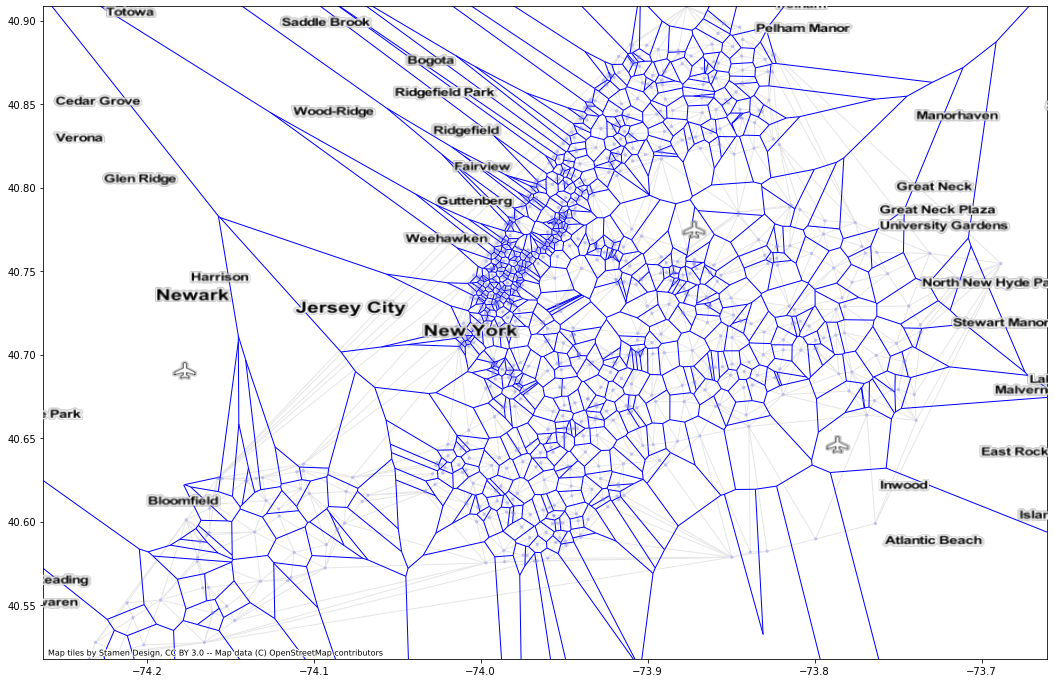

In [31]:
# Now we can show the Voronoi diagram using the test_sites and 0 weights.
test_sites, test_weights = site_measure["pos"], np.zeros(len(site_measure["pos"]))
tri_list, vor_vert = get_power_triangulation(test_sites, test_weights)
voronoi_cell_map = get_voronoi_cells(test_sites, vor_vert, tri_list)
display(test_sites, test_weights, tri_list, voronoi_cell_map)


In [134]:

from tqdm import tqdm
from shapely.geometry import Polygon, MultiPoint
import fiona
fiona.supported_drivers

class GeographicData():
    """
    A dataset class
    """
    
    def __init__(self, filename=None):
        try:
            if filename == None:
                self.gdf = gpd.read_file(gpd.datasets.get_path('nybb'))
            else:
                self.gdf = gpd.read_file(filename)
        except fiona.errors.DataIOError as err:
            raise TypeError

    def is_array_in_list(self, array, list_of_arrays):
        for a in list_of_arrays:
            if np.array_equal(array, a):
                return True
        return False

    def get_shapely_polygons(self, voronoi_cell_map):
        polygons_lst = []
        for key in voronoi_cell_map:
            value = voronoi_cell_map[key]
            # Convert value to polygon
            poly = []
            for edge, (A, U, tmin, tmax) in value:
                if tmin == -np.Inf:
                    tmin = -10.0
                if tmax == np.Inf:
                    tmax = 10.0
                pt_lft = A + tmin * U
                pt_rt = A + tmax * U
                if not self.is_array_in_list(pt_lft, poly) and np.isfinite(pt_lft).all():
                    poly.append(list(pt_lft))
                if not self.is_array_in_list(pt_rt, poly) and np.isfinite(pt_rt).all():
                    poly.append(list(pt_rt))

            if len(poly) > 0:
                poly_shp = Polygon(np.array(poly))
                if poly_shp.is_valid:
                    polygons_lst.append(poly_shp)
                else:
                    # clip polygon with boundary
                    pts = MultiPoint(poly_shp.exterior.coords[1:])
                    chull = pts.convex_hull
                    polygons_lst.append(chull)
        return polygons_lst

    def combine_dhs_voronoi(self, poly_lst):
        self.weighted_voronoi = self.gdf
        p = self.weighted_voronoi.shape[0]
        voronois = list(np.zeros(p))
        for i in tqdm(range(p)):
            pt = self.weighted_voronoi.loc[self.weighted_voronoi.index[i], 'geometry']
            for poly in poly_lst:
                if poly.contains(pt):
                    if voronois[i] == 0.0:
                        voronois[i] = poly
                        break
                    else:
                        print("cell not empty")

        self.weighted_voronoi['cells'] = voronois
        # drop geometry column and rename cells as geometry.
        self.weighted_voronoi = self.weighted_voronoi.drop(columns=['geometry'], axis=0)
        self.weighted_voronoi = self.weighted_voronoi.rename(columns={'cells': 'geometry'})


In [77]:
from shapely.geometry import Polygon, MultiPoint

class SemidiscreteOT:
    def __init__(self, dc_measure, ct_measure, learning_rate):
        self.sites = dc_measure
        self.density = ct_measure
        self.price = np.zeros(len(dc_measure["pos"]))
        self.lr = learning_rate
        self.tri_list, self.vor_vert = get_power_triangulation(
            self.sites["pos"], self.price)
        self.voronoi_cell_map = get_voronoi_cells(
            self.sites["pos"], self.vor_vert, self.tri_list)
        self.poly_lst = self.get_shapely_polygons()


    def price_iter(self, T):
        prices = []
        for t in range(T):
            print("The {} th iteration: ".format(t))
            grad = self.calc_diff()
            self.price += self.lr * grad
            prices.append(self.price)
            self.update_cell_map()
        return prices


    def is_array_in_list(self, array, list_of_arrays):
        for a in list_of_arrays:
            if np.array_equal(array, a):
                return True
        return False

    def update_cell_map(self):
        # This function will update the cellmap from the price/weight vector we get
        self.tri_list, self.vor_vert = get_power_triangulation(
            self.sites["pos"], self.price)
        self.voronoi_cell_map = get_voronoi_cells(
            self.sites["pos"], self.vor_vert, self.tri_list)

    def calc_diff(self):
        # For every vaccination site, set the demand-capacity difference to be the capacity
        diff = np.zeros_like(self.price)
        for id, voronoi_cell in enumerate(self.voronoi_cell_map):
            diff[id] = self.sites["cap"][id] - self.calc_demand(self.poly_lst[id], voronoi_cell)
        return diff

    def calc_demand_unif(self, polygon, voronoi_cell):
        # approximate the demand using integrated density 
        ar = polygon.area
        dmd = ar 
        return dmd
    
    def calc_demand(self, polygon, voronoi_cell):
        point_x = self.voronoi_cell_map[0][0][1][0][0]
        point_y = self.voronoi_cell_map[0][0][1][0][1]
        low_bounds = (point_x - d_lon, point_y - d_lat)
        high_bounds = (point_x + d_lon, point_y + d_lat)
        dmd = self.density.integrate_box(low_bounds, high_bounds)
        return dmd

    def get_shapely_polygons(self):
        polygons_lst = []
        for key in self.voronoi_cell_map:
            value = self.voronoi_cell_map[key]
            # Convert value to polygon
            poly = []
            for edge, (A, U, tmin, tmax) in value:
                if tmin == -np.Inf:
                    tmin = -10.0
                if tmax == np.Inf:
                    tmax = 10.0
                pt_lft = A + tmin * U
                pt_rt = A + tmax * U
                if not self.is_array_in_list(pt_lft, poly) and np.isfinite(pt_lft).all():
                    poly.append(list(pt_lft))
                if not self.is_array_in_list(pt_rt, poly) and np.isfinite(pt_rt).all():
                    poly.append(list(pt_rt))

            if len(poly) > 0:
                poly_shp = Polygon(np.array(poly))
                if poly_shp.is_valid:
                    polygons_lst.append(poly_shp)
                else:
                    # clip polygon with boundary
                    pts = MultiPoint(poly_shp.exterior.coords[1:])
                    chull = pts.convex_hull
                    polygons_lst.append(chull)
        return polygons_lst

    def plot_weighted_voronoi(self):
        fig, ax = plt.subplots(figsize=(18, 12))
        plt.axis('equal')

        # Set min/max display size, as Matplotlib does it wrong
        min_corner = np.amin(self.sites["pos"], axis=0) - np.max(self.price)
        max_corner = np.amax(self.sites["pos"], axis=0) + np.max(self.price)
        plt.xlim((min_corner[0], max_corner[0]))
        plt.ylim((min_corner[1], max_corner[1]))
        
        # Plot the sites
        for Si, Ri in zip(self.sites["pos"], self.price):
            ax.add_artist(plt.Circle(Si, 0.002, fill=True, alpha=.4,
                            lw=0., color='#8080f0', zorder=1))
        
        contextily.add_basemap(ax, crs="EPSG:4326",
                           source=contextily.providers.Stamen.TonerLabels)
        # Plot the power triangulation
        edge_set = frozenset(tuple(sorted(edge))
                         for tri in self.tri_list for edge in itertools.combinations(tri, 2))
        line_list = LineCollection([(self.sites["pos"][i], self.sites["pos"][j])
                               for i, j in edge_set], lw=1., colors='.9')
        line_list.set_zorder(0)
        ax.add_collection(line_list)

        # Plot the Voronoi cells
        edge_map = {}
        for segment_list in self.voronoi_cell_map.values():
            for edge, (A, U, tmin, tmax) in segment_list:
                edge = tuple(sorted(edge))
                if edge not in edge_map:
                    if tmax is np.Inf:
                        tmax = 10
                    if tmin is -np.Inf:
                        tmin = -10

                    edge_map[edge] = (A + tmin * U, A + tmax * U)

        line_list = LineCollection(edge_map.values(), lw=1., colors='b')
        line_list.set_zorder(0)
        ax.add_collection(line_list)
        plt.show()


semiot = SemidiscreteOT(dc_measure=site_measure,
                        ct_measure=gkernel, learning_rate=0.001)

prices = semiot.price_iter(10)



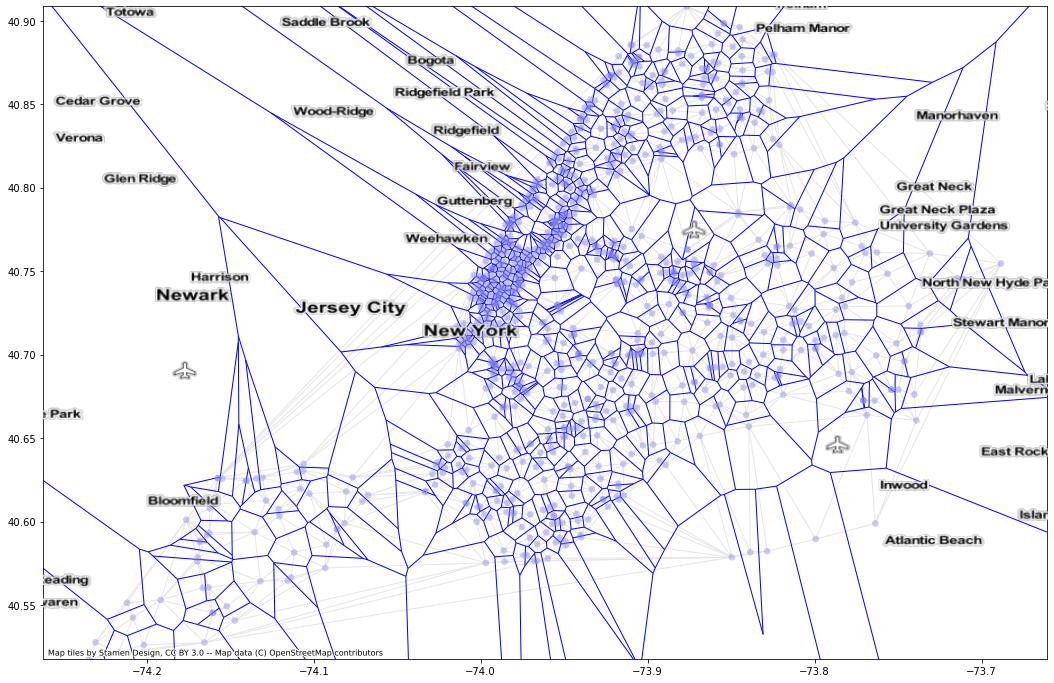

In [78]:
# Display the final outcome
semiot.plot_weighted_voronoi()